# 1. 학습데이터 준비

**scikit-learn이 제공하는 회귀 분석용 예제 데이터에 대해 소개한다. 먼저, 보스턴 주택 가격 데이터는 다음과 같이 구성되어 있다.**

* 타겟 데이터
    * 1978 보스턴 주택 가격
    * 506개 타운의 주택 가격 중앙값 (단위 1,000 달러)


* 특징 데이터
    * CRIM: 범죄율
    * INDUS: 비소매상업지역 면적 비율
    * NOX: 일산화질소 농도
    * RM: 주택당 방 수
    * LSTAT: 인구 중 하위 계층 비율
    * B: 인구 중 흑인 비율
    * PTRATIO: 학생/교사 비율
    * ZN: 25,000 평방피트를 초과 거주지역 비율
    * CHAS: 찰스강의 경계에 위치한 경우는 1, 아니면 0
    * AGE: 1940년 이전에 건축된 주택의 비율
    * RAD: 방사형 고속도로까지의 거리
    * DIS: 직업센터의 거리
    * TAX: 재산세율

In [46]:
from sklearn.datasets import load_boston

datasets = load_boston()

X = datasets.data
y = datasets.target
print(dir(datasets))

['DESCR', 'data', 'feature_names', 'filename', 'target']


In [47]:
print(datasets.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## 1-1. pandas로 변환 해보기

In [48]:
import pandas as pd

X_df = pd.DataFrame(datasets.data, columns=datasets.feature_names)
y_df = pd.DataFrame(datasets.target, columns=["price"])

In [49]:
df = pd.concat([X_df, y_df], axis=1)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 1-2. 시각화 해보기

In [50]:
import seaborn as sns

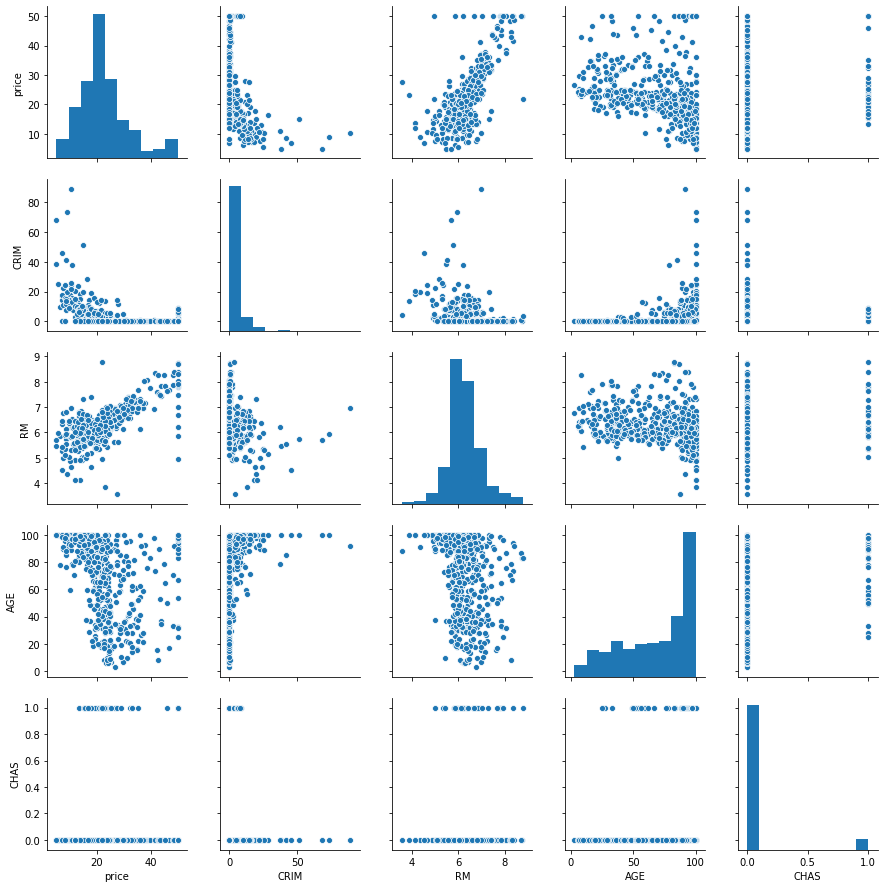

In [51]:
sns.pairplot(df[["price", "CRIM", "RM", "AGE", "CHAS"]])
plt.show()

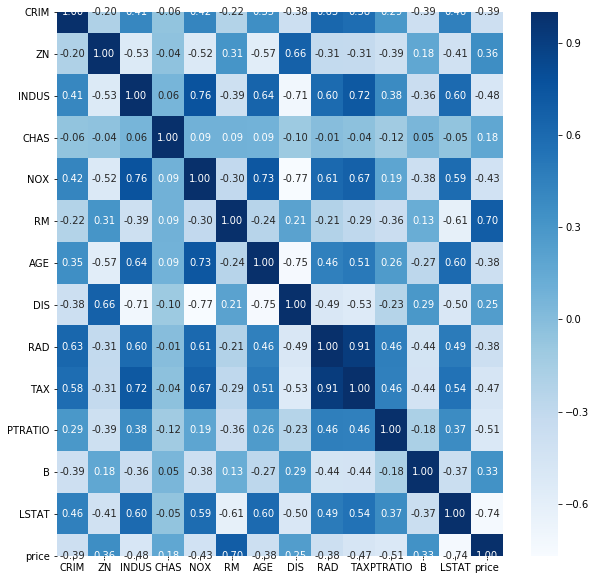

In [52]:
plt.figure(figsize=(10,10))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.2f', cmap='Blues')

## 1-3. 학습, 검증 데이터 나누기

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

## 1-4. 정규화  하기

### Z score Normalization:  $\frac{X - \mu}{\sigma}$ 

### min-max Normalization: $\frac{X - X_{min}}{X_{max} - X_{max}}$

In [54]:
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()

standardScaler.fit(X_train)

X_scaling_train = standardScaler.transform(X_train)
X_scaling_test = standardScaler.transform(X_test)

## 1-5. tensor로 매핑하기

In [55]:
import torch 

X_train_tensor = torch.tensor(X_scaling_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)

X_test_tensor = torch.tensor(X_scaling_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

# 2. Model 정의 (Linear Regression)

$y = Wx + b$

In [56]:
import torch
import torch.nn as nn

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size, bias=True)

    def forward(self, X):
        y = self.linear(X)
        return y

model = LinearRegression(1, 1)

In [57]:
model

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

# 3. Loss Function, Optimizer 정의

In [58]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# 4. 학습 하기

In [60]:
epochs = 1000

loss_train = []
for epoch in range(epochs):
    
    prediction = model(X_train_tensor[:,5].unsqueeze_(-1))
    loss = criterion(input=prediction, target=y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch:[{epoch}/{epochs}] Loss: {loss.item()}')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([339])) that is different to the input size (torch.Size([339, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:[0/1000] Loss: 619.0069580078125
Epoch:[10/1000] Loss: 598.171142578125
Epoch:[20/1000] Loss: 578.153076171875
Epoch:[30/1000] Loss: 558.9207153320312
Epoch:[40/1000] Loss: 540.4431762695312
Epoch:[50/1000] Loss: 522.6908569335938
Epoch:[60/1000] Loss: 505.6353454589844
Epoch:[70/1000] Loss: 489.24920654296875
Epoch:[80/1000] Loss: 473.5062561035156
Epoch:[90/1000] Loss: 458.3811340332031
Epoch:[100/1000] Loss: 443.8497009277344
Epoch:[110/1000] Loss: 429.88861083984375
Epoch:[120/1000] Loss: 416.4754943847656
Epoch:[130/1000] Loss: 403.5887756347656
Epoch:[140/1000] Loss: 391.2078857421875
Epoch:[150/1000] Loss: 379.3129577636719
Epoch:[160/1000] Loss: 367.8848571777344
Epoch:[170/1000] Loss: 356.9053039550781
Epoch:[180/1000] Loss: 346.356689453125
Epoch:[190/1000] Loss: 336.22210693359375
Epoch:[200/1000] Loss: 326.4853210449219
Epoch:[210/1000] Loss: 317.13067626953125
Epoch:[220/1000] Loss: 308.1431884765625
Epoch:[230/1000] Loss: 299.5083923339844
Epoch:[240/1000] Loss: 291

# 5. 테스트 하기

In [61]:
with torch.no_grad():
    model.eval()
    prediction = model(X_test_tensor[:,5].unsqueeze_(-1))
    print(prediction)

tensor([[19.8527],
        [19.8269],
        [19.8853],
        [19.8791],
        [19.8616],
        [19.8630],
        [19.8904],
        [19.8709],
        [19.8667],
        [19.8819],
        [19.8877],
        [19.8837],
        [19.9955],
        [19.8665],
        [19.9060],
        [19.8102],
        [19.8931],
        [19.9683],
        [19.7428],
        [19.8700],
        [19.8659],
        [19.8477],
        [19.9056],
        [19.8393],
        [19.8835],
        [19.9271],
        [19.8935],
        [19.8292],
        [19.8870],
        [19.8995],
        [19.9162],
        [19.8519],
        [19.7851],
        [19.9320],
        [19.8837],
        [19.9059],
        [19.7948],
        [19.8938],
        [19.8792],
        [19.8655],
        [19.9299],
        [19.8201],
        [19.7308],
        [19.9145],
        [19.8526],
        [19.9056],
        [19.9065],
        [19.8526],
        [19.8714],
        [19.8407],
        [19.8833],
        [19.8111],
        [19.

# 6. 결과 시각화

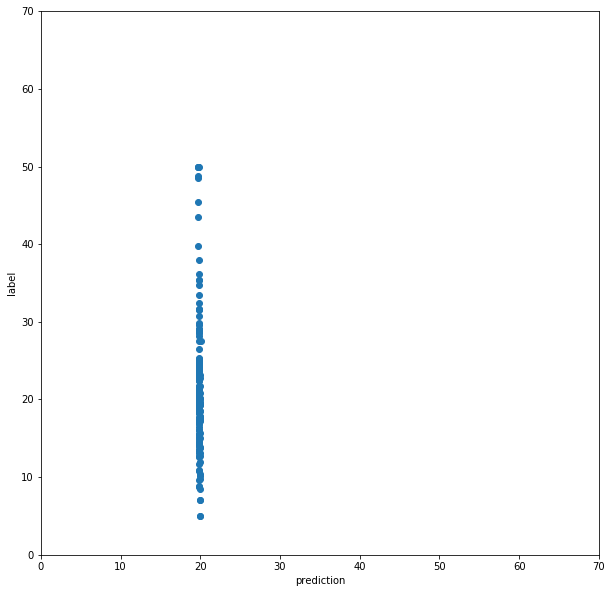

In [62]:
plt.figure(figsize=(10, 10))
plt.xlim(0, 70)
plt.ylim(0, 70)

plt.xlabel('prediction')
plt.ylabel('label')

plt.scatter(prediction, y_test)

# [부록] scikit-learn

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [64]:
standardScaler = StandardScaler()

standardScaler.fit(X_train)

X_scaling_train = standardScaler.transform(X_train)
X_scaling_test = standardScaler.transform(X_test)

In [65]:
linear_regression = LinearRegression()

linear_regression.fit(X_scaling_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [66]:
prediction = linear_regression.predict(X_scaling_test)

In [67]:
print(f'mse:{mean_squared_error(y_test, prediction)}, r2:{r2_score(y_test, prediction)}')

mse:20.72402343733975, r2:0.7261570836552478


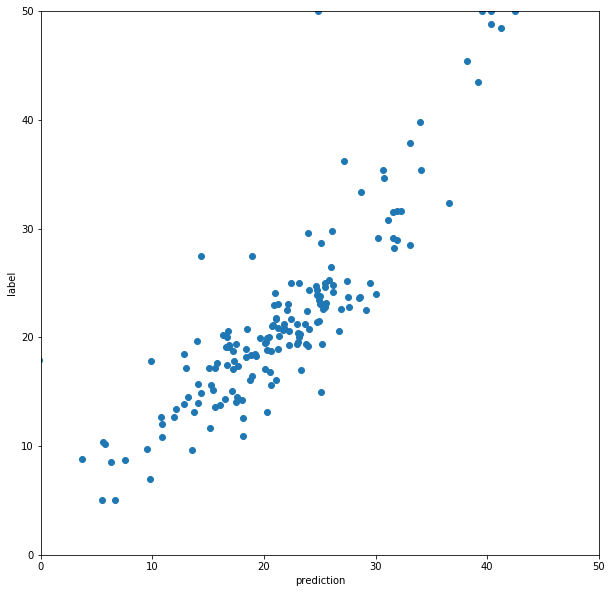

In [68]:
plt.figure(figsize=(10, 10))
plt.xlim(0, 50)
plt.ylim(0, 50)

plt.xlabel('prediction')
plt.ylabel('label')

plt.scatter(prediction, y_test)